# Import packages

In [1]:
#import matplotlib.pyplot as plt
#import numpy as np
#import sys
#import time
#import ROOT
#import pandas as pd
#from root_pandas import read_root
#from matplotlib.ticker import NullFormatter
#import matplotlib as mpl
#from iminuit import Minuit, describe, Struct
#import astroML.plotting as aml
from array import array
import itertools
import time

import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting.style import get_style, set_style
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import matplotlib.pyplot as plt
import numpy as np

import astroML.plotting as aml
import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
#from ROOT import TApplication as TAP
from matplotlib.ticker import NullFormatter


Welcome to JupyROOT 6.13/01


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


# Define Bins

In [2]:
zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
pTbins = [10, 11, 12.5, 16]

# Phi Projection & ZYAM

###### NOTE: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to true for signal, false for not signal (a.k.a. background)

In [3]:
def GetPhiProj(filename, ipt, izt, Signal_DNN=True, doZYAM=True):
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))

    Eta_Axis = histo2D.GetYaxis()
    PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6));
    PhiProjection.SetDirectory(0)
    ntriggers = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    PhiProjection.Scale(1.0/ntriggers.GetEntries())
    
    zyam = PhiProjection.Integral(11,13)/3
    # how do I plot ZYAM, perhaps in both cases?
    #print('ZYAM=%f'%(zyam))
    if(doZYAM):
        for i in range(25):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error) 

    return PhiProjection

SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed.

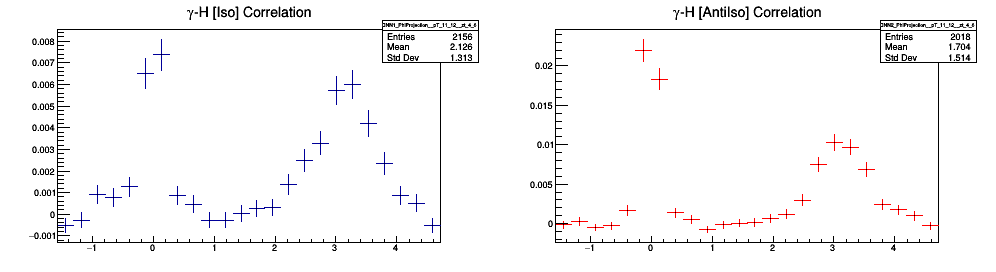

In [15]:
canv = ROOT.TCanvas("canv","canv",1000,300)
canv.Divide(2,1)
Sig = GetPhiProj('Same_Mix_Ratio.root',1,3,True,True)#equal to returned plot
canv.cd(1)
Sig.Draw()
bkgd = GetPhiProj('Same_Mix_Ratio.root',1,3,False,True)
canv.cd(2)
bkgd.SetLineColor(2)
bkgd.Draw()
canv.Draw()

# Low DNN Subtraction

In [24]:
def GetBKGsubtracted(filename, ptbin, ztbin, doZYAM=True):
    Sig_Subtr_Bkgd = GetPhiProj(filename,ptbin,ztbin,True,doZYAM)
    Raw=Sig_Subtr_Bkgd.Clone()
    Background = GetPhiProj(filename,ptbin,ztbin,False,doZYAM)
    #purity = GetBinContent(ptbin)
    purity = 0.4
    Background.Scale(purity)
    Sig_Subtr_Bkgd.Add(Background,-1)
    return Sig_Subtr_Bkgd,Raw,Background

###### I have checked the error bars manually, root in this case handles them correctly when adding histograms (sumed in quadrature)

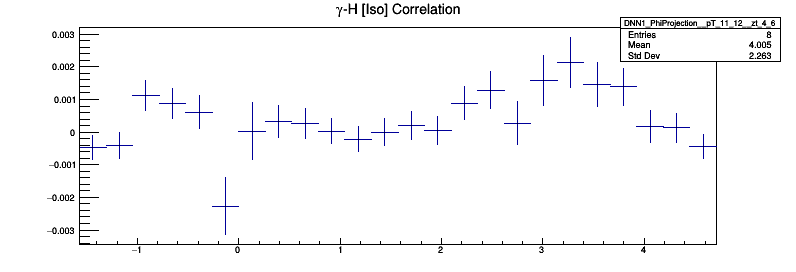

In [26]:
c = ROOT.TCanvas("c","c",800,300)
ROOT.enableJSVis()
hsub,hraw,hbkd = GetBKGsubtracted('Same_Mix_Ratio.root',1,3,True)
hsub.Draw()
c.Draw()
ROOT.disableJSVis()

In [39]:
def Looping(filename):
    for ptbin in range(3):
        canvas = ROOT.TCanvas()
        canvas.Divide(3,3)
        for ztbin in range(7):
            hsub,hraw,hbkg = GetBKGsubtracted(filename,ptbin,ztbin,True)#Do ZYAM
            canvas.cd(ztbin) 
            hraw.Draw()
            hbkg.SetLineColor(2)
            hbkg.Draw('same')
        canvas.SaveAs('correlations_ptbin%i_.png'%(ptbin))

In [40]:
Looping('Same_Mix_Ratio.root')

INFO:ROOT.TCanvas.Print] png file correlations_ptbin0_.png has been created
INFO:ROOT.TCanvas.Print] png file correlations_ptbin1_.png has been created
INFO:ROOT.TCanvas.Print] png file correlations_ptbin2_.png has been created
